In [ ]:
pwd

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/labeled_tweets.csv')

In [ ]:
blue = pd.read_csv('/content/drive/MyDrive/dolar_blue_fut.csv')

In [ ]:
features = pd.read_csv('/content/drive/MyDrive/features.csv')

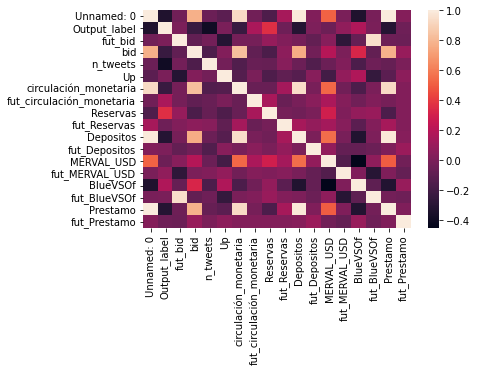

In [ ]:
import seaborn as sns
sns.heatmap(features.corr())

In [ ]:
#Convertir fechas desde object a datetimes
blue['fecha'] = pd.to_datetime(blue['fecha'])
df['created_at'] = pd.to_datetime(df['created_at'])

In [ ]:
df = df[df.created_at != 'created_at']

In [ ]:
#Cruzar tweeters con información del dolar
df_blue = df.merge(blue, left_on='created_at', right_on='fecha', how='outer')

In [ ]:
#Eliminar las fechas sin tweeters
df_blue.dropna(subset = ['created_at'], inplace=True)
print(df_blue.shape)

(1093773, 52)


In [ ]:
#Eliminar filas duplicadas
df_blue = df_blue.drop_duplicates()
print(df_blue.shape)

(1093773, 52)


In [ ]:
def merge_fechas(df1, df2, criteria = 'forward'):
  df3 = df1.merge(df2, left_on='created_at', right_on='fecha', how='outer')
  df3.dropna(subset = ['created_at'], inplace=True)
  df3 = df3.sort_values(by="created_at")
  if criteria == 'forward':
    df3[['bid','ask']] = df3[['bid','ask']].fillna(method="ffill")
    df3[['bid','ask']] = df3[['bid','ask']].fillna(method="bfill")
  if criteria == 'drop':
    df3.dropna(subset = ['fut_bid'], inplace=True)

In [ ]:
df_blue = df_blue.sort_values(by="created_at")
df_blue.head(3)

,Unnamed: 0_x,Unnamed: 0.1,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,quote_id,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_id,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified,Probas,Most_Prob,NEG,POS,NEU,Unnamed: 0_y,fecha,bid,ask,dif_ask,dif_bid,perc_ask,perc_bid,fut_ask,fut_bid
4879,2709.0,2710.0,NaN,2020-04-25,coronavirus cuarentena Aislamiento QuedateEnCa...,https://twitter.com/evaquijano/status/12538873...,NaN,3.0,1.253887e+18,NaN,NaN,NaN,es,NaN,False,NaN,0.0,NaN,NaN,"<a href=""http://twitter.com/download/android"" ...","en la 🍐, vos sabés que sí\n\n#coronavirus\n#cu...",https://twitter.com/evaquijano/status/12538873...,Sun Dec 11 20:30:05 +0000 2011,434403911.0,False,💚 Lic. en Comunicación Social\n💜 Estudianta de...,11632.0,1809.0,876.0,8.0,La Plata-Bs As-Argentina,Eva Quijano,evaquijano,13437.0,NaN,NaN,False,"SentimentOutput(output=NEU, probas={NEU: 0.999...",NEU,0.001,0.001,0.999,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5767,3597.0,3598.0,NaN,2020-04-25,CoronavirusEnArgentina Covid_19,NaN,https://bit.ly/3bDgKGS https://spoti.fi/2Y4Tux...,7.0,1.254077e+18,NaN,NaN,NaN,es,NaN,False,NaN,5.0,NaN,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Escucha la columna de este viernes de nuestro ...,https://twitter.com/Razonyre/status/1254076716...,Thu Nov 11 00:40:23 +0000 2010,214275191.0,False,Organización socialista. Queremos expropiar la...,1147.0,2236.0,1455.0,14.0,Argentina Prensa 11 5869-2726,Razón y Revolución,Razonyre,5989.0,NaN,http://www.razonyrevolucion.org,False,"SentimentOutput(output=POS, probas={POS: 0.550...",POS,0.011,0.550,0.438,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5766,3596.0,3597.0,NaN,2020-04-25,NaN,NaN,https://twitter.com/PGSMurray/status/125404409...,6.0,1.254077e+18,NaN,NaN,NaN,es,NaN,False,1.254044e+18,2.0,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",La industria del dildo también podría jugar un...,https://twitter.com/PackFestichola/status/1254...,Sun Jan 31 04:55:21 +0000 2010,110050189.0,False,En el horóscopo uruguayo soy vaso de requesón,107704.0,1113.0,507.0,3.0,Uruguay,Industria Uruguaya,PackFestichola,27376.0,NaN,NaN,False,"SentimentOutput(output=NEU, probas={NEU: 0.988...",NEU,0.002,0.009,0.988,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_blue[['fecha','fut_bid', 'bid']] = df_blue[['fecha','fut_bid', 'bid']].fillna(method="ffill")
df_blue.dropna(subset = ['fecha'], inplace=True)
df_blue.head(3)

,Unnamed: 0_x,Unnamed: 0.1,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,quote_id,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_id,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified,Probas,Most_Prob,NEG,POS,NEU,Unnamed: 0_y,fecha,bid,ask,dif_ask,dif_bid,perc_ask,perc_bid,fut_ask,fut_bid
4317,8573.0,8576.0,NaN,2020-04-27,NaN,NaN,https://twitter.com/portalmvd/status/125484091...,6.0,1.254923e+18,NaN,NaN,NaN,es,NaN,False,1.254841e+18,3.0,NaN,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Va de nuevo: casi 3 millones de dolares. La mi...,https://twitter.com/SuenaUruguay/status/125492...,Sun Jun 28 00:45:06 +0000 2009,5.160547e+07,False,Todo sobre la música en Uruguay,29581.0,6737.0,2799.0,20.0,"Montevideo, Uruguay",Suena Uruguay,SuenaUruguay,112711.0,NaN,https://open.spotify.com/user/lmt9kiv3uev1noqy...,False,"SentimentOutput(output=NEU, probas={NEU: 0.870...",NEU,0.126,0.004,0.870,79.0,2020-04-27,109.0,118.0,1.0,1.0,0.85,0.93,2.0,2.0
4310,8566.0,8569.0,NaN,2020-04-27,NaN,NaN,https://www.airedesantafe.com.ar/santa-fe/por-...,10.0,1.254923e+18,NaN,NaN,NaN,es,NaN,False,NaN,4.0,NaN,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",SANTA FE | El número de infectados por Covid-1...,https://twitter.com/AiredeSantaFe/status/12549...,Thu Apr 23 15:40:32 +0000 2009,3.464384e+07,False,NaN,517.0,42905.0,386.0,167.0,"Santa Fe, Argentina",Aire de Santa Fe,AiredeSantaFe,279649.0,NaN,https://www.airedigital.com,True,"SentimentOutput(output=NEU, probas={NEU: 0.991...",NEU,0.007,0.003,0.991,79.0,2020-04-27,109.0,118.0,1.0,1.0,0.85,0.93,2.0,2.0
4316,8572.0,8575.0,NaN,2020-04-27,NaN,NaN,https://www.udigital.uy/msp-emergencia-sanitar...,2.0,1.254921e+18,NaN,NaN,NaN,es,NaN,False,NaN,0.0,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Hombre de 91 años es la decimoquinta víctima d...,https://twitter.com/udigitaluy/status/12549206...,Wed Sep 11 15:20:29 +0000 2013,1.854599e+09,False,Portal de Noticias de Uruguay,1803.0,6633.0,757.0,30.0,Uruguay,Udigital,udigitaluy,7120.0,NaN,http://www.udigital.uy,False,"SentimentOutput(output=NEG, probas={NEG: 0.994...",NEG,0.994,0.001,0.004,79.0,2020-04-27,109.0,118.0,1.0,1.0,0.85,0.93,2.0,2.0


In [ ]:
#Desagregar la fecha en DOW, semana, mes y año
df_blue['DOW'] = df_blue['fecha'].dt.weekday+1
df_blue['Week'] = df_blue['fecha'].dt.weekofyear
df_blue['Month'] = df_blue['fecha'].dt.month
df_blue['Year'] = df_blue['fecha'].dt.year
df_blue.head(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0_x,Unnamed: 0.1,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,quote_id,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_id,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified,Probas,Most_Prob,NEG,POS,NEU,Unnamed: 0_y,fecha,bid,ask,dif_ask,dif_bid,perc_ask,perc_bid,fut_ask,fut_bid,DOW,Week,Month,Year
4317,8573.0,8576.0,NaN,2020-04-27,NaN,NaN,https://twitter.com/portalmvd/status/125484091...,6.0,1.254923e+18,NaN,NaN,NaN,es,NaN,False,1.254841e+18,3.0,NaN,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Va de nuevo: casi 3 millones de dolares. La mi...,https://twitter.com/SuenaUruguay/status/125492...,Sun Jun 28 00:45:06 +0000 2009,51605473.0,False,Todo sobre la música en Uruguay,29581.0,6737.0,2799.0,20.0,"Montevideo, Uruguay",Suena Uruguay,SuenaUruguay,112711.0,NaN,https://open.spotify.com/user/lmt9kiv3uev1noqy...,False,"SentimentOutput(output=NEU, probas={NEU: 0.870...",NEU,0.126,0.004,0.87,79.0,2020-04-27,109.0,118.0,1.0,1.0,0.85,0.93,2.0,2.0,1,18,4,2020


In [ ]:
df_blue['Output_label'] = df_blue.Most_Prob.map({'POS':1, 'NEU':0, 'NEG':0})
df_blue['Output_neg'] = df_blue.Most_Prob.map({'POS':0, 'NEU':0, 'NEG':1})

In [ ]:
import numpy as np
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [ ]:
df_blue['indice'] = df_blue['POS'] + df_blue['NEG']
df2 = df_blue.groupby('fecha').agg({'indice':'mean'}).reset_index()
df2['prediction'] = df2.indice.map(lambda x: sigmoid(x))
(1/(aux.Up.count()))*np.sum(aux['Up']*np.log(df2['prediction']) - (1-aux['Up'])*np.log(1-(df2['prediction'])))
#(1-aux['Up'].to_numpy())*np.log(1-(df2['prediction']))
#np.log(1-(df2['prediction']))
aux['Up']*np.log(df2['prediction']) - (1-aux['Up'])*np.log(1-(df2['prediction']))

0     -0.512040
1      0.918038
2      0.918298
3     -0.500136
4      0.908162
         ...   
335    0.934814
336    0.927426
337    0.934056
338    0.906602
339    0.915944
Length: 340, dtype: float64

In [ ]:
def tweet_index(df, a, b, c, d):
  df['indice'] = a*df['POS'] + b*df['NEG'] + c
  df2 = df.groupby('fecha').agg({'indice':'mean'}).reset_index()
  return df2.sort_values(by="fecha")

def gradient(dfX,Y ,a, b, c, d):
    pass  # YOUR CODE HERE
    df2 = tweet_index(dfX, a, b, c, d)
    df2['prediction'] = df2.indice.map(lambda x: sigmoid(x))
    d_a = np.sum(tweet_index(dfX,1,0,0,d).indice*(df2.prediction-Y))
    d_b = np.sum(tweet_index(dfX,0,1,0,d).indice*(df2.prediction-Y))
    d_c = np.sum(tweet_index(dfX,0,0,1,d).indice*(df2.prediction-Y))
    return d_a, d_b, d_c

def loss(dfX, Y, a, b, c, d):
  df2 = tweet_index(dfX, a, b, c, d)
  df2['prediction'] = df2.indice.map(lambda x: sigmoid(x))
  df2.sort_values(by="fecha")
  return (1/(Y.count()))*np.sum(Y*np.log(df2['prediction']) - (1-Y)*np.log(1-(df2['prediction'])))

def steps(d_a,d_b,d_c, learning_rate = 0.01):
    pass  # YOUR CODE HERE
    step_a = d_a*learning_rate
    step_b = d_b*learning_rate
    step_c = d_c*learning_rate
    return step_a, step_b, step_c

def update_params(a, b, c, step_a, step_b, step_c):
    pass  # YOUR CODE HERE
    a_new = a - step_a
    b_new = b - step_b
    c_new = c - step_c
    return a_new , b_new, c_new

In [ ]:
print(loss(df_blue, aux.Up, 2, 2, 1, 1.5))
update_params(1,1,1, *steps(*gradient(df_blue, aux['Up'], 1, 1, 1, 1.5), learning_rate=0.005))

0.6990932284988898


(0.9586957042260732, 0.8362372383959302, 1.0)

In [ ]:
np.sum(tweet_index(df_blue,0,1,-1,1.5).indice.to_numpy())

124.29389675910119

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
a = 0
b = 0
c = 0
d = 0
n_epoch = 200
loss_history = [loss(df_blue, aux.Down,a,b,c,d)]
a_history = [a]
b_history = [b]
c_history = [c]

for epoch in tqdm(range(n_epoch)):
    new_a = update_params(a,b,c, *steps(*gradient(df_blue, aux.Down, a, b, c, d), learning_rate=0.005))[0]
    new_b = update_params(a,b,c, *steps(*gradient(df_blue, aux.Down, a, b, c, d), learning_rate=0.005))[1]
    new_c = update_params(a,b,c, *steps(*gradient(df_blue, aux.Down, a, b, c, d), learning_rate=0.005))[2]
    a = new_a
    b = new_b
    c = new_c
    loss_history.append(loss(df_blue, aux.Down,a,b,c,d))
    a_history.append(a)
    b_history.append(b)
    c_history.append(c)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
a_history[-1],b_history[-1],c_history[-1]

(-0.14223054541848337, -0.2721699969717113, -0.8052792052961709)

In [ ]:
a,b,c = a_history[-1],b_history[-1],c_history[-1]
best_label = tweet_index(df_blue, a, b, c, 1.5)
best_label['predictor'] = best_label.indice.map(lambda x : sigmoid(x))
best_label['prediction'] = best_label.predictor.map(lambda x: 1 if x > 0.366 else 0)
best_label
#def threshold_opt(df):
#  df['prediction'] = df.predictor.map(lambda x: 1 if x > threshold else 0)
df_validación = aux.merge(best_label, on='fecha', how='inner')
df_validación['correct'] = df_validación['Down'] ==  df_validación['prediction']
df_validación.correct.value_counts()

True     243
False     97
Name: correct, dtype: int64

In [ ]:
aux = df_blue.groupby('fecha').agg({'Output_label':'sum','Output_neg':'sum', 'fut_bid':'mean', 'bid':'mean', 'text': 'count'}).reset_index()
aux['Up'] = aux.fut_bid.map(lambda x: 1 if x >= 0.8 else 0)
aux['Down'] = aux.fut_bid.map(lambda x: 1 if x <= -0.8 else 0)
aux['Cte'] = aux.fut_bid.map(lambda x: 1 if x > -0.8 and x < 0.8 else 0)
#df_dia = aux.merge(blue[['fecha','bid','fut_bid']], left_on='fecha', right_on='fecha', how='outer')
#df_dia.dropna(subset = ['Output_label'], inplace=True)
aux.rename(columns = {'text':'n_tweets'}, inplace = True)
aux.sort_values(by="fecha")
aux.head(15)
#aux[aux['Output_label']<-0.3]

,fecha,Output_label,Output_neg,fut_bid,bid,n_tweets,Up,Down,Cte
0,2020-04-27,454,1268,2.00,109.00,4340,1,0,0
1,2020-04-28,230,698,0.20,111.00,2329,0,0,1
2,2020-04-29,193,708,-2.40,111.20,2259,0,1,0
3,2020-04-30,854,2304,1.60,108.80,7451,1,0,0
4,2020-05-04,171,549,0.60,110.40,1898,0,0,1
5,2020-05-05,180,553,2.00,111.00,1968,1,0,0
6,2020-05-06,202,574,0.00,113.00,2051,0,0,1
7,2020-05-07,317,615,0.20,113.00,2337,0,0,1
8,2020-05-08,376,1116,2.60,113.20,3457,1,0,0
9,2020-05-11,169,515,2.40,115.80,1847,1,0,0


(<matplotlib.axes._subplots.AxesSubplot at 0x7f1858126150>,
               Output_label  Output_neg   fut_bid       bid  n_tweets        Up
 Output_label      1.000000    0.921608 -0.014122 -0.159943  0.965272  0.016175
 Output_neg        0.921608    1.000000 -0.015739 -0.091121  0.982887 -0.000361
 fut_bid          -0.014122   -0.015739  1.000000 -0.081917 -0.023890 -0.311403
 bid              -0.159943   -0.091121 -0.081917  1.000000 -0.149418  0.048303
 n_tweets          0.965272    0.982887 -0.023890 -0.149418  1.000000  0.009625
 Up                0.016175   -0.000361 -0.311403  0.048303  0.009625  1.000000)

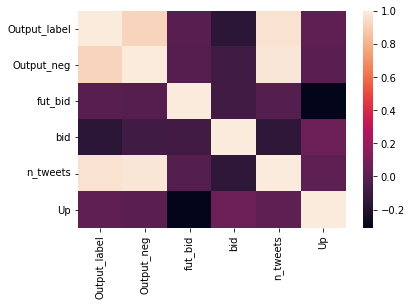

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(aux.corr()), aux.corr()

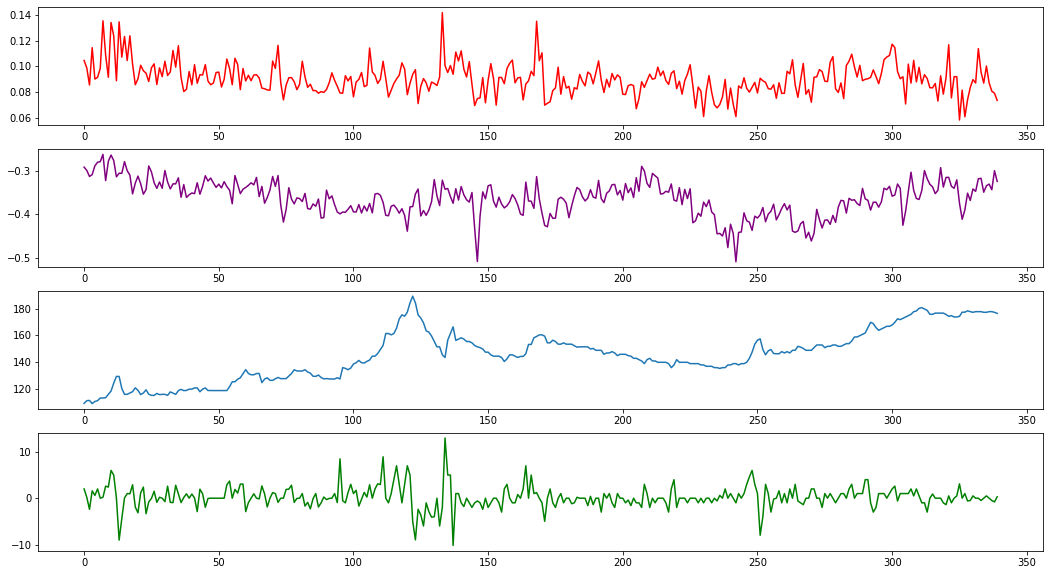

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(18,10))
axs[0].plot(aux.Output_label, c='red')
axs[1].plot(-aux.Output_neg, c='purple')
axs[2].plot(aux.bid)
axs[3].plot(aux.fut_bid, c='green')

In [ ]:
aux.to_csv('output_df.csv')

In [ ]:
!cp output_df.csv "drive/My Drive/"

In [ ]:
AVAILABLE_LANGS = ['es', 'en']
import emoji

def check_valid_lang(lang):
    if lang not in AVAILABLE_LANGS:
        raise Exception(f'There is no stopwords file for {lang}.') 

def read_stopwords(lang):
    '''Reads stopword file, returns a list of stopwords.'''
    check_valid_lang(lang)
    with open(f'../stopwords/stopwords_{lang}.txt', 'r') as fi:
        stop_words = fi.read()
    return stop_words.split()

def remove_emojis(data):
    #return re.sub(r':[^: ]+?:', '', tweet)
    #return emoji.get_emoji_regexp().sub(r'', tweet.decode('utf8'))
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [ ]:
import string
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


def prep(text):
    text = remove_emojis(text).strip()
    text = re.sub(r'http\S+', '', text).strip()
    text = re.sub(r'#', '', text).strip()
    text = re.sub(r'@\S+', '', text).strip()
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    text = text.lower()
    text = ''.join(word for word in text if not word.isdigit())
    stop_words = set(stopwords.words('spanish'))
    word_tokens = word_tokenize(text)
    text = ' '.join(w for w in word_tokens if not w in stop_words)
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word) for word in word_tokens]
    text = ' '.join(w for w in lemmatized)
    return text.strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
df_blue['text_prep'] = df_blue.text.map(lambda x : prep(x))

In [ ]:
texto = '#lado b covid #pasando @patologías ✍️ gustavo sar httpshola que suba el dolar'
prep(texto)

'lado b covid pasando gustavo sar suba dolar'